In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.4 MB/s 
     |████████████████████████████████| 7.6 MB 24.3 MB/s 
     |████████████████████████████████| 163 kB 54.0 MB/s 


In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from PIL import Image

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"joshuasirusstara","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c socs-hackathon-ai-final-phase-final-onsite

100% 342M/342M [00:15<00:00, 24.7MB/s]
100% 342M/342M [00:15<00:00, 23.1MB/s]


In [ ]:
#Extract compressed dataset
with zipfile.ZipFile('/content/socs-hackathon-ai-final-phase-final-onsite.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
order = sorted([str(i) for i in range(11)])

In [ ]:
df = pd.read_csv('caption_true.csv',index_col=0)

In [ ]:
df.tail()

,text,label
1998,a room with a lot of paintings on the wall,9.0
1999,a subway train is stopped at a train station,9.0
2000,a train is parked at a train station,9.0
2001,people standing at a terminal waiting for thei...,9.0
2002,a train station with people walking around,9.0


In [ ]:
df.label = df.label.astype('int')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import tensorflow_addons as tfa

In [ ]:
data_dir = '/content/train/train'

batch_size = 16
img_size = (224, 224)

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  # validation_split=0.2,
  # subset="training",
  shuffle=False,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

# val_ds = keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   shuffle=False,
#   seed=123,
#   image_size=img_size,
#   batch_size=batch_size)

Found 2003 files belonging to 11 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


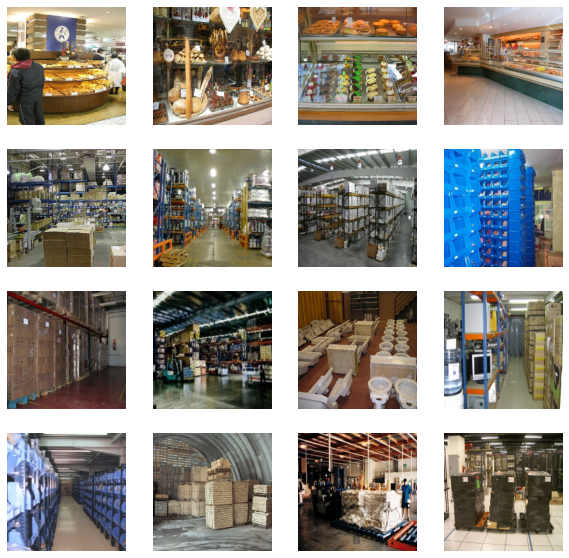

In [ ]:
# class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(23):
    # print(labels)
    for i,image in enumerate(images):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
BATCH_SIZE=16
MAX_LENGTH = 128
SHUFFLE_BUFFER_SIZE=10000

In [ ]:
from transformers import TFRobertaForSequenceClassification,ViTFeatureExtractor, TFViTForImageClassification, RobertaTokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
model_id = 'google/vit-base-patch16-224'

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, RobertaTokenizer

def convert_sentence_to_features(sentence,tokenizer):
    return tokenizer.encode_plus(
        sentence,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )


def map_features_to_dict(image_list, input_ids_list, attention_masks_list, label_list=[],token_type_ids_list=[]):
    dict_={}
    if len(token_type_ids_list) > 0:
      if len(label_list) > 0:
        dict_ = {
          'image':image_list,
          'input_ids': input_ids_list,
          'token_type_ids' : token_type_ids_list,
          'attention_mask': attention_masks_list,
        }, label_list
      else:
        dict_ = {
          'image':image_list,
          'input_ids': input_ids_list,
          'token_type_ids' : token_type_ids_list,
          'attention_mask': attention_masks_list,
        }
    else:
      if len(label_list) > 0:
        dict_ = {
          'image':image_list,
          'input_ids': input_ids_list,
          'attention_mask': attention_masks_list,
        }, label_list
      else:
        dict_ = {
          'image':image_list,
          'input_ids': input_ids_list,
          'attention_mask': attention_masks_list,
        }
    return dict_

def encode_sentences(dataset, imageset,tokenizer, evaluation=False):
    input_ids_list = []
    token_type_ids_list = []
    attention_masks_list = []
    label_list = []
    image_list = []
    tensor_dataset = []
    if evaluation:
      for images in imageset:
        for image in images:
          image_list.append(image)
      for message in tfds.as_numpy(dataset):
        bert_input = convert_sentence_to_features(message.decode(),tokenizer)
        input_ids_list.append(bert_input['input_ids'])
        attention_masks_list.append(bert_input['attention_mask'])
        if 'token_type_ids' in bert_input:
          token_type_ids_list.append(bert_input['token_type_ids'])
    else:
      for images,label in imageset:
        for image in images:
          image_list.append(image)

      for message, label in tfds.as_numpy(dataset):
        bert_input = convert_sentence_to_features(message.decode(),tokenizer)
        input_ids_list.append(bert_input['input_ids'])
        attention_masks_list.append(bert_input['attention_mask'])
        label_list.append([label])

        if 'token_type_ids' in bert_input:
          token_type_ids_list.append(bert_input['token_type_ids'])
    # print(attention_masks_list)
    if len(token_type_ids_list) > 0:
      if len(label_list) > 0:
        tensor_dataset = tf.data.Dataset.from_tensor_slices((image_list, input_ids_list, attention_masks_list, label_list, token_type_ids_list))
      else:
        tensor_dataset = tf.data.Dataset.from_tensor_slices((image_list, input_ids_list, attention_masks_list, token_type_ids_list))
    else:
      if len(label_list) > 0:
        tensor_dataset = tf.data.Dataset.from_tensor_slices((image_list, input_ids_list, attention_masks_list, label_list))
      else:
        tensor_dataset = tf.data.Dataset.from_tensor_slices((image_list, input_ids_list, attention_masks_list))

    return tensor_dataset.map(map_features_to_dict)

In [ ]:
tensor_train = tf.data.Dataset.from_tensor_slices((df['text'].values,df['label'].values))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train_encoded = encode_sentences(tensor_train,train_ds,tokenizer=tokenizer).cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
  ]
)

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = img_size + (3,)

In [ ]:
vit_model = TFViTForImageClassification.from_pretrained(model_id)

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [ ]:
def vit_preprocess_input(img):

    mean = feature_extractor.image_mean
    std = feature_extractor.image_std

    # Scale to the value range of [0, 1] first and then normalize.
    img = img / 255
    mean = tf.constant(mean)
    std = tf.constant(std)
    img = (img - mean) / std

    return tf.transpose(img, (0,3,1,2))

In [ ]:
roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base',num_hidden_layers=8)

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['roberta/encoder/layer_._8/output/dense/kernel:0', 'roberta/encoder/layer_._11/attention/output/dense/kernel:0', 'roberta/encoder/layer_._9/attention/self/query/bias:0', 'roberta/encoder/layer_._10/output/LayerNorm/beta:0', 'roberta/encoder/layer_._8/attention/self/query/kernel:0', 'roberta/encoder/layer_._11/intermediate/dense/bias:0', 'roberta/encoder/layer_._11/output/dense/bias:0', 'roberta/encoder/layer_._9/output/LayerNorm/gamma:0', 'roberta/encoder/layer_._9/attention/output/LayerNorm/gamma:0', 'roberta/encoder/layer_._9/attention/self/key/kernel:0', 'roberta/encoder/layer_._11/output/LayerNorm/gamma:0', 'roberta/encoder/layer_._11/attention/self/key/kernel:0', 'roberta/encoder/layer_._8/attention/self/value/kernel:0', 'roberta/encoder/layer_._10/attention/output/LayerNorm/gamma:0', 'roberta/encoder/layer_._10/attention/self/query/kernel:0', 'roberta/encoder

In [ ]:
image = layers.Input(shape=IMG_SHAPE, dtype='float32',name='image')

input_ids = tf.keras.Input(shape=(128, ),dtype='int32',name= 'input_ids')
# token_type_ids = tf.keras.Input(shape=(256, ), dtype='int32',name= 'token_type_ids')
attention_mask = tf.keras.Input(shape=(128, ), dtype='int32',name= 'attention_mask')

# roberta
r = roberta([input_ids,attention_mask])[0]

#vit
aug = data_augmentation(image)
v = vit_preprocess_input(aug)
v = vit_model.vit(v)[0]

x = layers.Concatenate()([v[:, 0, :],r]);
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(11, activation="softmax")(x)

model = keras.Model(inputs=[image,input_ids,attention_mask], outputs = [outputs])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(ds_train_encoded,
                        # validation_data=valid_ds,
                         epochs=1)

126/126 [==============================] - 110s 876ms/step - loss: 0.1894 - accuracy: 0.9556


In [ ]:
df = pd.read_csv('caption_test.csv')

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
  '/content/test/test',
  label_mode=None,
  seed=123,
  image_size=img_size,
  batch_size=batch_size,
  shuffle=False
  )

Found 1167 files belonging to 1 classes.


In [ ]:
tensor_test = tf.data.Dataset.from_tensor_slices((df['text'].values))

In [ ]:
ds_test_encoded = encode_sentences(tensor_test,test_ds,tokenizer=tokenizer,evaluation=True).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
res = model.predict(ds_test_encoded)

73/73 [==============================] - 22s 299ms/step


In [ ]:
result = res.argmax(-1)

In [ ]:
result

array([0, 0, 0, ..., 9, 9, 0])

In [ ]:
dict_index = {}

In [ ]:
for dirname, _, filenames in os.walk(f"/content/test/test"):
    for i,filename in enumerate(sorted(filenames)):
      dict_index[filename] = result[i]

In [ ]:
results=pd.DataFrame({"label":[dict_index[f"test ({i}).jpg"] for i in range(1,len(result)+1)]})
results.to_csv("results2.csv",mode='w', columns=['label'], index_label='index', index=True)